## Solar Energy Projects - Outlier analysis and regression

### Contents
#### 1. Importing libraries and data
#### 2. Data cleaning (removing outliers)
#### 3. Prepare regression analysis
##### 3.1 Hypothesis to test
#### 4. Regression analysis

### 1. Importing libraries and data

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [46]:
path = r'C:\Users\ii\OneDrive\02052023Solar Programs NY'

In [47]:
#first uploading the dataset that is already cleaned from previous exercises and includes a new variable - i.e., installation size
df1 = pd.read_pickle(os.path.join(path, '02. Prepared data','solar_power_new.pkl'))

### 2. Data cleaning (removing outliers)

In [48]:
df1.columns

Index(['index', 'project_number', 'city', 'county', 'state', 'zip_code',
       'sector', 'program_type', 'electric_utility', 'purchase_type',
       'date_application_received', 'project_status', 'inverter_quantity',
       'pv_quantity', 'project_cost', 'incentive', 'kw_dc', 'kwh_year',
       'affordable_solar', 'community_distributed_generation', 'location_data',
       'installation_size'],
      dtype='object')

In [49]:
df1.head(20)

,index,project_number,city,county,state,zip_code,sector,program_type,electric_utility,purchase_type,...,inverter_quantity,pv_quantity,project_cost,incentive,kw_dc,kwh_year,affordable_solar,community_distributed_generation,location_data,installation_size
0,0,5137-49041,Maine,Broome,NY,13802,Residential,Residential/Small Commercial,NYS Electric and Gas,Lease,...,2.0,40.0,41800.00,6930.0,10.00,11738.0,False,False,"Maine, NY 13802\n(42.240938, -76.047937)",Small Solar
1,1,5137-46019,Levittown,Nassau,NY,11756,Residential,Residential/Small Commercial,PSEG Long Island,Lease,...,1.0,28.0,30940.00,2520.0,7.00,8217.0,False,False,"Levittown, NY 11756\n(40.725845, -73.517198)",Small Solar
2,2,5137-52151,Cortland,Cortland,NY,13045,Residential,Residential/Small Commercial,National Grid,Lease,...,2.0,49.0,48387.50,11025.0,12.25,14380.0,False,False,"Cortland, NY 13045\n(42.588691, -76.185061)",Small Solar
3,3,5129-94109,Staten Island,Richmond,NY,10314,Residential,Residential/Small Commercial,Consolidated Edison,Purchase,...,1.0,15.0,23509.54,2943.0,4.91,5758.0,False,False,"Staten Island, NY 10314\n(40.604049, -74.152798)",Small Solar
4,4,5137-46454,Warwick,Orange,NY,10990,Residential,Residential/Small Commercial,Orange and Rockland Utilities,Lease,...,1.0,22.0,25283.00,5720.0,5.72,6714.0,False,False,"Warwick, NY 10990\n(41.263165, -74.365461)",Small Solar
5,5,5129-60647-GJ,Ronkonkoma,Suffolk,NY,11749,Residential,Residential/Small Commercial,PSEG Long Island,Purchase,...,2.0,23.0,33106.06,2256.0,7.52,8828.0,False,False,"Ronkonkoma, NY 11749\n(40.807149, -73.173128)",Small Solar
6,6,5137-57452,Slingerlands,Albany,NY,12159,Residential,Residential/Small Commercial,National Grid,Lease,...,1.0,21.0,20737.50,4200.0,5.25,6163.0,False,False,"Slingerlands, NY 12159\n(42.646421, -73.874892)",Small Solar
7,7,5137-51508,Amityville,Suffolk,NY,11701,Residential,Residential/Small Commercial,PSEG Long Island,Lease,...,1.0,23.0,22712.50,2300.0,5.75,6750.0,False,False,"Amityville, NY 11701\n(40.686478, -73.414186)",Small Solar
8,8,5137-46921,Schenectady,Schenectady,NY,12304,Residential,Residential/Small Commercial,National Grid,Lease,...,3.0,67.0,74035.00,11613.0,16.75,19662.0,False,False,"Schenectady, NY 12304\n(42.778181, -73.902335)",Small Solar
9,9,5137-41728,Staten Island,Richmond,NY,10303,Residential,Residential/Small Commercial,Consolidated Edison,Lease,...,2.0,35.0,36575.00,8750.0,8.75,10271.0,False,False,"Staten Island, NY 10303\n(40.629735, -74.162953)",Small Solar


In [50]:
df1.shape

(75564, 22)

This dataframe has more than 5000 entries, so it can work well in a linear regression analysis. 

##### Duplicates check

In [51]:
dups = df1.duplicated()

In [52]:
dups.shape # No dups

(75564,)

##### Extreme values checks

We know from the previous tasks that the data set has extreme values in PV production. Let's check them again

In [54]:
df1['kwh_year'].mean() # Check the mean

27323.83185114605

In [55]:
df1['kwh_year'].median() # Check the median

8452.0

In [56]:
df1['kwh_year'].max() # Check the max

6807591.0

The mean, median and max values show the skewedness of the data. There are outliers with very large installations, compared to the majority of PV installation which produces below 100000 KWh_year.

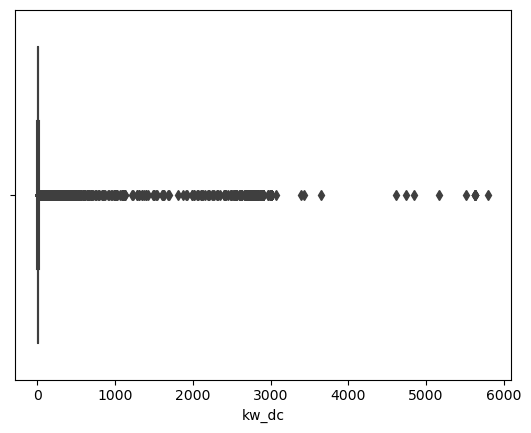

In [57]:
sns.boxplot (x=df1['kw_dc'])
plt.show()

In [58]:
df1['kw_dc'].describe ()

count    75564.000000
mean        23.278069
std        190.160234
min          0.250000
25%          5.220000
50%          7.200000
75%          9.950000
max       5799.420000
Name: kw_dc, dtype: float64

With the describe method of pandas, we can see our data’s Q1 (%25) and Q3 (%75) percentiles. We can calculate our IQR point and boundaries (with 1.5).

In [59]:
#use Tukey's rule to dectect outliers, or IQR rule. 
df1['kw_dc'].quantile (0.25)

5.22

In [60]:
df1['kw_dc'].quantile (0.75)

9.95

In [61]:
#calculate interquartile range
Q1=df1['kw_dc'].quantile (0.25)
Q3=df1['kw_dc'].quantile (0.75)
IQR= Q3-Q1

In [62]:
IQR

4.7299999999999995

In [63]:
lower_limit= Q1-1.5*IQR
upper_limit= Q3+1.5*IQR

In [64]:
lower_limit

-1.8749999999999991

In [65]:
upper_limit

17.044999999999998

This result means values between -1.8 and 17 are acceptable but those outside this range are outliers

In [66]:
#dealine with outliers
outliers_low= (df1 ['kw_dc'] < lower_limit)

In [67]:
outliers_high= (df1 ['kw_dc'] > upper_limit)

In [68]:
#checking how many rows would be left in the dataset without these outliers
len(df1 ['kw_dc'])-(len(df1['kw_dc'][outliers_low])+ len(df1['kw_dc'][outliers_high]))

70970

In [69]:
#shows data the outliers
df1['kw_dc'][(outliers_low|outliers_high)]

35       105.60
45        17.25
51        40.96
68        86.80
69        29.70
          ...  
84579     20.40
84601     17.60
84621     82.35
84642     49.28
84697     61.60
Name: kw_dc, Length: 4594, dtype: float64

The length of the rows we lose is 4594 entries

In [70]:
#shows the data without the outliers
df1['kw_dc'][~(outliers_low|outliers_high)]

0        10.00
1         7.00
2        12.25
3         4.91
4         5.72
         ...  
84716     8.50
84717     6.50
84718     7.95
84719     5.72
84720     9.80
Name: kw_dc, Length: 70970, dtype: float64

We are still left with a dataset of 70970 rows

In [77]:
df2=df1 [~(outliers_low|outliers_high)]

In [80]:
df2.head()

,index,project_number,city,county,state,zip_code,sector,program_type,electric_utility,purchase_type,...,inverter_quantity,pv_quantity,project_cost,incentive,kw_dc,kwh_year,affordable_solar,community_distributed_generation,location_data,installation_size
0,0,5137-49041,Maine,Broome,NY,13802,Residential,Residential/Small Commercial,NYS Electric and Gas,Lease,...,2.0,40.0,41800.00,6930.0,10.00,11738.0,False,False,"Maine, NY 13802\n(42.240938, -76.047937)",Small Solar
1,1,5137-46019,Levittown,Nassau,NY,11756,Residential,Residential/Small Commercial,PSEG Long Island,Lease,...,1.0,28.0,30940.00,2520.0,7.00,8217.0,False,False,"Levittown, NY 11756\n(40.725845, -73.517198)",Small Solar
2,2,5137-52151,Cortland,Cortland,NY,13045,Residential,Residential/Small Commercial,National Grid,Lease,...,2.0,49.0,48387.50,11025.0,12.25,14380.0,False,False,"Cortland, NY 13045\n(42.588691, -76.185061)",Small Solar
3,3,5129-94109,Staten Island,Richmond,NY,10314,Residential,Residential/Small Commercial,Consolidated Edison,Purchase,...,1.0,15.0,23509.54,2943.0,4.91,5758.0,False,False,"Staten Island, NY 10314\n(40.604049, -74.152798)",Small Solar
4,4,5137-46454,Warwick,Orange,NY,10990,Residential,Residential/Small Commercial,Orange and Rockland Utilities,Lease,...,1.0,22.0,25283.00,5720.0,5.72,6714.0,False,False,"Warwick, NY 10990\n(41.263165, -74.365461)",Small Solar


In [79]:
df2.columns

Index(['index', 'project_number', 'city', 'county', 'state', 'zip_code',
       'sector', 'program_type', 'electric_utility', 'purchase_type',
       'date_application_received', 'project_status', 'inverter_quantity',
       'pv_quantity', 'project_cost', 'incentive', 'kw_dc', 'kwh_year',
       'affordable_solar', 'community_distributed_generation', 'location_data',
       'installation_size'],
      dtype='object')

C:\Users\isobr\OneDrive\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='kwh_year', ylabel='Density'>

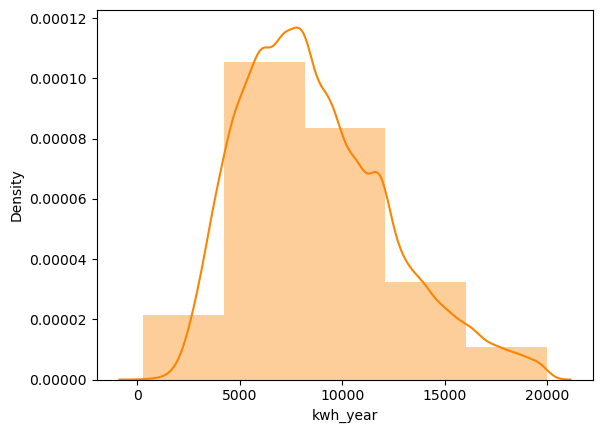

In [81]:
sns.distplot(df2['kwh_year'], color='#fb8500', bins=5)

In [105]:
#export Df without outliers
df2.to_pickle(os.path.join(path, '02. Prepared data', 'solar_no_outliers.pkl'))

### 3. Prepare regression analysis

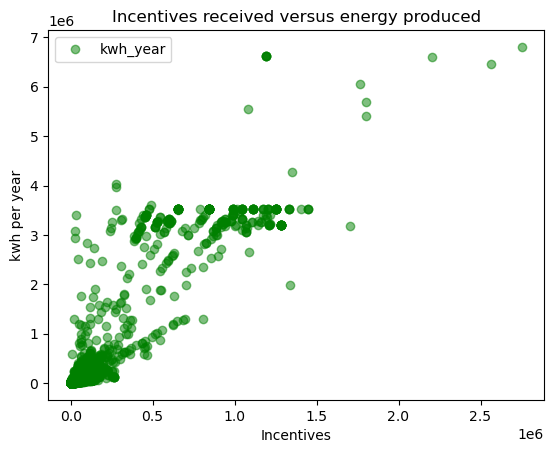

In [82]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

df1.plot(x = 'incentive', y='kwh_year',style='o',color='green', alpha=0.5) # alpha argument to play with opacity
plt.title('Incentives received versus energy produced')  
plt.xlabel('Incentives')  
plt.ylabel('kwh per year')  
plt.show()

#### 3.1 Hypothesis to test
H1. Incentives have created a boost in PV installations

### 4. Regression Analysis

In [83]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = df2['incentive'].values.reshape(-1,1)
y = df2['kwh_year'].values.reshape(-1,1)

In [84]:
X

array([[ 6930.],
       [ 2520.],
       [11025.],
       ...,
       [ 3180.],
       [ 5040.],
       [ 3920.]])

In [85]:
y

array([[11738.],
       [ 8217.],
       [14380.],
       ...,
       [ 9332.],
       [ 6714.],
       [11504.]])

In [86]:
# Split data into a training set and a test set, using 30% of the data for the test and 70% for training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Create a regression object and predict values

In [87]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [88]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [89]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

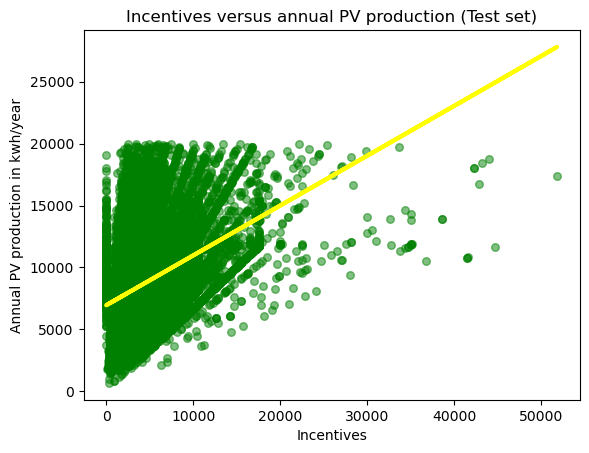

In [90]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='green', s = 30, alpha=0.5) # s to play with the size of the dots
plot_test.plot(X_test, y_predicted, color='yellow', linewidth =3)
plot_test.title('Incentives versus annual PV production (Test set)')
plot_test.xlabel('Incentives')
plot_test.ylabel('Annual PV production in kwh/year')
plot_test.show()

We still see most points at the bottom that are away from the line, so it is important to check statiscal measures that tell us more about the validity of the model

In [91]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [92]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.40258483]]
Mean squared error:  10721490.845866079
R2 score:  0.18341886653222406


The slope indicates the variation is positive, nevertheless the MSE is quite big and the R2 score almost null, which shows the model is not a good fit for the data. 

In [93]:
#checking the predicted values
y_predicted

array([[ 7197.92472421],
       [ 9440.3222052 ],
       [ 7535.29080842],
       ...,
       [10371.90349263],
       [ 6949.12730172],
       [ 7870.64396851]])

In [94]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(20)

,Actual,Predicted
0,5494.0,7197.924724
1,14526.0,9440.322205
2,8546.0,7535.290808
3,3592.0,8153.049172
4,6750.0,8060.261422
5,5987.0,8468.482435
6,16786.0,7732.154788
7,16058.0,8050.599386
8,4026.0,8329.993255
9,15266.0,9000.409714


These results confirm the lack of fitness of the model there is a huge difference between the predicted and the atual values.

##### Compare how the regression fits the training set

In [95]:
# Predict.

y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [96]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [97]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.40258483]]
Mean squared error:  10514314.034413049
R2 score:  0.18129789606312052


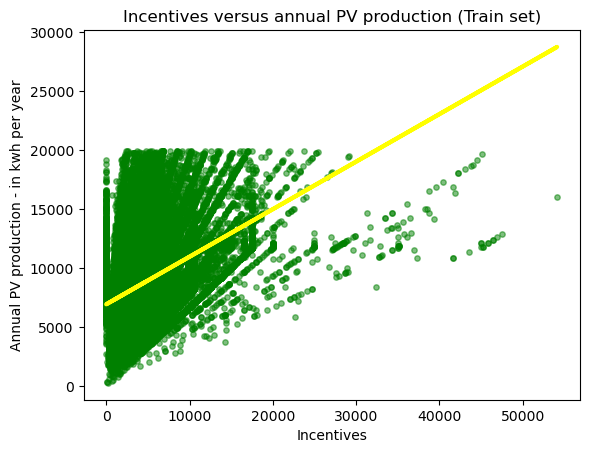

In [98]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X_train, y_train, color='green', s = 15, alpha=0.5)
plot_test.plot(X_train, y_predicted_train, color='yellow', linewidth =3)
plot_test.title('Incentives versus annual PV production (Train set)')
plot_test.xlabel('Incentives')
plot_test.ylabel('Annual PV production - in kwh per year')
plot_test.show()

In [125]:
#Now trying a regression with more than one independent variable
# Reshape the variables into NumPy arrays and put them into separate objects.

X = df2['project_cost'].values.reshape(-1,1)
y = df2['kwh_year'].values.reshape(-1,1)

In [126]:
X

array([[41800.  ],
       [30940.  ],
       [48387.5 ],
       ...,
       [28051.52],
       [21148.  ],
       [37740.  ]])

In [127]:
X.shape

(70970, 1)

In [103]:
y

array([[11738.],
       [ 8217.],
       [14380.],
       ...,
       [ 9332.],
       [ 6714.],
       [11504.]])

When removing the outliers this script indicates that the regression is an even weaker model to apply, as the R2 value decreases further. Other type of analysis is required to understand the relationships between variables. 